# Import for testcode

In [1]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import csv
from tabulate import tabulate
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights, ResNet50_Weights, resnet50
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import optuna
from sklearn.model_selection import train_test_split
import os


# TrainData Preprocess with dataLoad

In [2]:
torch.set_num_threads(1)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
model_name = 'RESNET'
test_transform = transforms.Compose([
        transforms.Resize((227, 227)), 
        transforms.ToTensor()
])

Batch_Size = 4

test_dir = "your test dataset"
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=Batch_Size, shuffle =False)
class_names = test_dataset.classes
num_classes = len(class_names)

weights = models.ResNet50_Weights.IMAGENET1K_V1
model = models.resnet50(weights=weights)
classifier = model.fc
last_layer_in_features = classifier.in_features
model.fc = nn.Linear(last_layer_in_features, num_classes)

FileNotFoundError: [Errno 2] No such file or directory: 'your test dataset'

# Model Load
youn need train models like **.pth  
here we use auroc.pth for test  
you can use anything which you want to test   
ex) loss, accuracy.. by val  

In [ ]:
model.load_state_dict(torch.load('../auroc.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Calculating 

aim to calculate model
such as precision, recall, f1 etc..


In [101]:
def calculate_avg_metrics(all_labels, all_preds, average):
    overall_precision = precision_score(
        all_labels, all_preds, average=average, zero_division=0)
    overall_recall = recall_score(
        all_labels, all_preds, average=average, zero_division=0)
    overall_f1 = f1_score(all_labels, all_preds,
                          average=average, zero_division=0)
    return overall_precision, overall_recall, overall_f1

def calculate_class_metrics(class_labels, class_preds):
    precision = precision_score(class_labels, class_preds, zero_division=0)
    recall = recall_score(class_labels, class_preds, zero_division=0)
    f1 = f1_score(class_labels, class_preds, zero_division=0)
    return precision, recall, f1

def mean_absolute_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    absolute_errors = np.abs(y_true - y_pred)
    mae = np.mean(absolute_errors)
    return mae

# Model Test

In [102]:
model.eval()

# Initialize lists for result storage
all_preds = []
all_labels = []
f1_scores = []
all_proba = []

# Initialize labels and predictions for each class
class_labels = [[], [], [], []]
class_preds = [[], [], [], []]
class_probas = [[], [], [], []]
class_probas_idx = [[], [], [], []]

# Disable automatic gradient computation
with torch.no_grad():
    # Create CSV file and write header
    data_record_csv = "test_data_record.csv"
    with open(data_record_csv, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(["True Label", "Data name", "MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"])
        
        # Batch processing through data loader
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)  # Move data to appropriate device
            outputs = model(images)  # Perform prediction through the model
            _, preds = torch.max(outputs, 1)  # Extract class with highest probability
            probabilities = F.softmax(outputs, dim=1)  # Calculate probabilities for each class

            # Store results
            all_preds.extend(preds.cpu().numpy())  # Store prediction results
            all_labels.extend(labels.cpu().numpy())  # Store actual labels
            all_proba.extend(probabilities.cpu().numpy())  # Store probabilities
            
            # For each image in the batch
            for i, (label, pred, prob) in enumerate(zip(labels, preds, probabilities)):
                class_labels[label].append(label.cpu().item())
                class_preds[label].append(pred.cpu().item())
                class_probas[label].append(prob.cpu().numpy())
                # Get file path of current image
                
                img_path = test_dataset.samples[batch_idx * Batch_Size + i][0]
                # Extract only file name
                img_name = os.path.basename(img_path)
                
                # Write to CSV file
                formatted_probs = ["{:.2f}".format(p.item() * 100) for p in prob]
                csv_writer.writerow([label.item(), img_name, *formatted_probs])


# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_proba = np.array(all_proba)

# Print results
print("Predictions and labels saved.")


Predictions and labels saved.


[[147   6  10  17]
 [  0  12   0   1]
 [  4   2 413  69]
 [  5   1  47 327]]


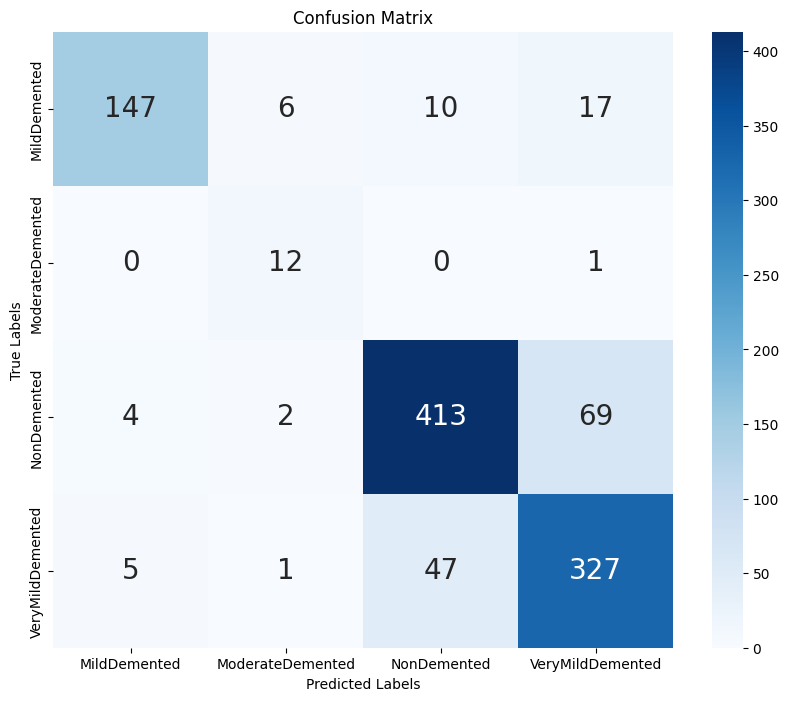

In [103]:
cm = confusion_matrix(all_labels, all_preds)
print(cm)

# plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 20})

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_mat.png')
plt.show()

In [104]:
# Plot the ROC curve for each class
plt.figure(figsize=(10, 10))

fpr = dict()
tpr = dict()
roc_auc = dict()
class_labels_list = []
class_probas_list = []

table_rows = []
total_class_acc = 0
class_top2_recall_list = []
top2_recall_total = 0
balance_acc_total = 0
total_mae = 0

top_k_acc_csv = model_name+'_top_k_pred.csv'
total_macro_auroc = 0


with open(top_k_acc_csv, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    # Calculate metrics for each class

    for class_index in range(4):  # Replace num_classes with the actual number of classes
        print('class index : ', class_index)
        class_preds_bin = (all_preds == class_index)
        class_labels_bin = (all_labels == class_index)
        class_probas_bin = all_proba[:, class_index]
        for class_label in class_labels_bin:
            class_labels_list.append(class_label)
        for class_proba in class_probas_bin:
            class_probas_list.append(class_proba)
            
        second_max_list = []
        for array in class_probas[class_index]:
            second_max = np.partition(array,-2)[-2]
            second_max_idx = np.where(array == second_max)[0][0]
            second_max_list.append(second_max_idx)
        
        mae = mean_absolute_error(class_labels[class_index],class_preds[class_index])
        total_mae += mae
        
        csv_writer.writerow(["class_labels", class_labels[class_index]])
        csv_writer.writerow(["class_preds", class_preds[class_index]])
        csv_writer.writerow(["second_max_list", second_max_list])
        csv_writer.writerow(["mae",mae])
        csv_writer.writerow([])
        
        fpr[class_index], tpr[class_index], _ = roc_curve(
            class_labels_bin, class_probas_bin)
        # Calculate the area under the ROC curve (AUC)
        roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])
        total_macro_auroc += roc_auc[class_index]

        accuracy = cm[class_index][class_index] / np.sum(cm[class_index])
        balance_acc_total += accuracy
        
        precision, recall, f1 = calculate_class_metrics(
        class_labels_bin, class_preds_bin)
        f1_scores.append(f1)
        class_name = class_names[class_index]

        count_top2_idx = np.sum(np.array(second_max_list) == class_index)
        top2_recall = (cm[class_index][class_index] + count_top2_idx) / np.sum(cm[class_index])
        top2_recall_total += top2_recall

        class_top2_recall_list.append(top2_recall)
        table_rows.append([class_name, roc_auc[class_index], mae, precision, recall, f1, top2_recall])

avg_mae = total_mae / 4




class index :  0
class index :  1
class index :  2
class index :  3


<Figure size 1000x1000 with 0 Axes>

+------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      Class       |       Auroc        |         MAE         |     Precision      |       Recall       |      F1 Score      |    Top2 Recall     |      Accuracy      |
+------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   MildDemented   | 0.9769706142010341 | 0.42777777777777776 | 0.9423076923076923 | 0.8166666666666667 |       0.875        | 0.9444444444444444 |                    |
| ModerateDemented | 0.996843805049912  | 0.15384615384615385 | 0.5714285714285714 | 0.9230769230769231 | 0.7058823529411765 | 0.9230769230769231 |                    |
|   NonDemented    | 0.9536305896489571 | 0.16188524590163936 | 0.8787234042553191 | 0.8463114754098361 | 0.8622129436325678 | 0.9795081967213115 |        

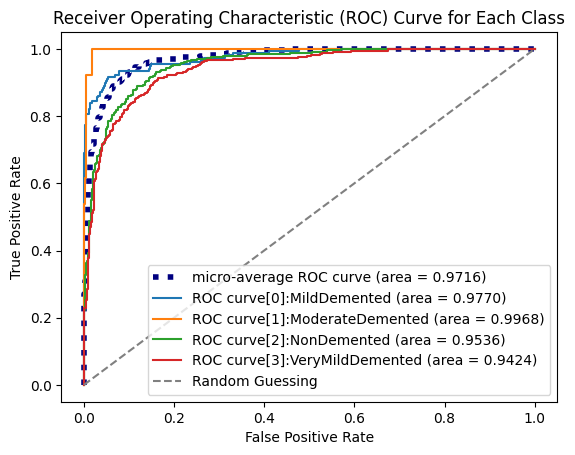

In [105]:
# Print the table
fpr["micro"], tpr["micro"], _ = roc_curve(class_labels_list, class_probas_list)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
roc_auc["macro"] = total_macro_auroc / 4


all_fpr = np.unique(np.concatenate(
    [fpr[class_index] for class_index in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for class_index in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[class_index], tpr[class_index])
    
    
mean_tpr = mean_tpr/num_classes

macro_top2_recall = top2_recall_total / 4

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='navy', linestyle=':', linewidth=4)


for class_index in range(num_classes):
    plt.plot(fpr[class_index], tpr[class_index],
             label='ROC curve[{0}]:{1} (area = {2:0.4f})'
             ''.format(class_index, class_names[class_index], roc_auc[class_index]))


micro_precision, micro_recall, micro_f1 = calculate_avg_metrics(all_labels, all_preds, "micro")
macro_precision, macro_recall, macro_f1 = calculate_avg_metrics(all_labels, all_preds, "macro")


micro_top2_recall = top_k_accuracy_score(all_labels,all_proba,k=2)
# Calculate micro and macro accuracy
micro_accuracy = accuracy_score(all_labels, all_preds)
macro_accuracy = np.mean([accuracy_score(all_labels[all_labels == i], all_preds[all_labels == i]) for i in range(num_classes)])

# Add micro and macro accuracy to the metrics table
micro_metrics = [roc_auc['micro'], "", micro_precision, micro_recall, micro_f1, micro_top2_recall, micro_accuracy]
macro_metrics = [roc_auc["macro"], avg_mae, macro_precision, macro_recall, macro_f1, macro_top2_recall, macro_accuracy]

# Append micro and macro metrics to table rows
table_rows.append(["Macro", *macro_metrics])
table_rows.append(["Micro", *micro_metrics])

# Define table headers to include Accuracy
table_headers = ["Class", "Auroc", "MAE", "Precision", "Recall", "F1 Score", "Top2 Recall", "Accuracy"]
print(tabulate(table_rows, headers=table_headers, tablefmt="pretty"))

# Plotting and saving the figure as before
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend()
plt.savefig(model_name+'_auroc.png')
plt.show()





In [115]:

##
csv_file_path = model_name+'_metrics_results.csv'
csv_class_names = class_names


with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    # Write header
    csv_writer.writerow(["Class", "Auroc", "MAE", "Precision", "Recall", "F1 Score" ,"Top2 Recall" ,"Accuracy"])
    # Write class-wise metrics
    for class_index in range(4):
        csv_writer.writerow([
            class_names[class_index],
            "{:.3f}".format(table_rows[class_index][1]),  # auroc
            "{:.3f}".format(table_rows[class_index][2]),  # mae
            "{:.3f}".format(table_rows[class_index][3]),  # precision
            "{:.3f}".format(table_rows[class_index][4]),  # recall
            "{:.3f}".format(table_rows[class_index][5]),  # f1
            "{:.3f}".format(table_rows[class_index][6]),  # top2 recall
        ])
        
    csv_writer.writerow([
        'macro',
        "{:.3f}".format(roc_auc["macro"]),  # auroc
        "{:.3f}".format(macro_metrics[1]),  # mae
        "{:.3f}".format(macro_metrics[2]),  # precision
        "{:.3f}".format(macro_metrics[3]),  # recall
        "{:.3f}".format(macro_metrics[4]),  # f1
        "{:.3f}".format(macro_metrics[5]),  # top2 recall
        "{:.3f}".format(macro_metrics[6]),  # accuracy
    ])
    csv_writer.writerow([
        'micro',
        "{:.3f}".format(micro_metrics[0]),  # auroc
        (micro_metrics[1]),  # mae
        "{:.3f}".format(micro_metrics[2]),  # precision
        "{:.3f}".format(micro_metrics[3]),  # recall
        "{:.3f}".format(micro_metrics[4]),  # f1
        "{:.3f}".format(micro_metrics[5]),  # top2 recall
        "{:.3f}".format(micro_metrics[6]),  # accuracy
    ])

csv_file.close()

In [116]:

##
csv_full_file_path = model_name+'_full_metrics_results.csv'
csv_full_class_names = class_names

with open(csv_full_file_path, 'w', newline='') as csv_file_full:
    csv_writer = csv.writer(csv_file_full)
    # Write header
    csv_writer.writerow(["Class", "Auroc", "MAE", "Precision", "Recall", "F1 Score" ,"Top2 Recall","Accuracy"])
    # Write class-wise metrics
    for class_index in range(4):
        csv_writer.writerow([
            class_names[class_index],
            (table_rows[class_index][1]),  # auroc
            (table_rows[class_index][2]),  # mae
            (table_rows[class_index][3]),  # precision
            (table_rows[class_index][4]),  # recall
            (table_rows[class_index][5]),  # f1
            (table_rows[class_index][6]),  # top2 recall
        ])
    csv_writer.writerow([
        'macro',
        (total_macro_auroc/7),  # auroc
        (macro_metrics[1]),  # mae
        (macro_metrics[2]),  # precision
        (macro_metrics[3]),  # recall
        (macro_metrics[4]),  # f1
        (macro_metrics[5]),  # top2 recall
        (macro_metrics[6]),  # accuracy
        
    ])
    csv_writer.writerow([
        'micro',
        (micro_metrics[0]),  # auroc
        (micro_metrics[1]),  # mae
        (micro_metrics[2]),  # precision
        (micro_metrics[3]),  # recall
        (micro_metrics[4]),  # f1
        (micro_metrics[5]),  # top2 recall
        (micro_metrics[6]),  # accuracy
    ])

csv_file_full.close()
